In [1]:
import pynucastro as pyna
from pynucastro.rates import ReacLibRate, TabularRate

In [2]:
DO_DERIVED_RATES = True

In [3]:
reaclib_lib = pyna.ReacLibLibrary()
weak_lib = pyna.TabularLibrary()

In [4]:
# these are the nuclei we have in subch_simple
all_reactants = ["p",
                 "he4", "c12", "o16", "ne20", "mg24", "si28", "s32",
                 "ar36", "ca40", "ti44", "cr48", "fe52", "ni56",
                 "al27", "p31", "cl35", "k39", "sc43", "v47", "mn51", "co55",
                 "n13", "n14", "f18", "ne21", "na22", "na23"]

In [5]:
# create a library of ReacLib rates
core_lib = reaclib_lib.linking_nuclei(all_reactants)

In [6]:
# in this list, we have the reactants, the actual reactants,
# and modified products that we will use instead

other_rates = [("c12(c12,n)mg23", "mg24"),
               ("o16(o16,n)s31", "s32"),
               ("o16(c12,n)si27", "si28")]

for r, mp in other_rates:
    _r = reaclib_lib.get_rate_by_name(r)
    _r.modify_products(mp)
    core_lib.add_rate(_r)

In [7]:
# finally, the aprox nets don't include the reverse rates for
# C12+C12, C12+O16, and O16+O16, so remove those

for r in core_lib.get_rates():
    if sorted(r.products) in [[pyna.Nucleus("c12"), pyna.Nucleus("c12")],
                              [pyna.Nucleus("c12"), pyna.Nucleus("o16")],
                              [pyna.Nucleus("o16"), pyna.Nucleus("o16")]]:
        core_lib.remove_rate(r)

# C12+Ne20 and reverse
# (a,g) links between Na23 and Al27
# (a,g) links between Al27 and P31

rates_to_remove = ["p31(p,c12)ne20",
                   "si28(a,c12)ne20",
                   "ne20(c12,p)p31",
                   "ne20(c12,a)si28",
                   "na23(a,g)al27",
                   "al27(g,a)na23",
                   "al27(a,g)p31",
                   "p31(g,a)al27"]

for r in rates_to_remove:
    print("removing: ", r)
    _r = core_lib.get_rate_by_name(r)
    core_lib.remove_rate(_r)

removing:  p31(p,c12)ne20
removing:  si28(a,c12)ne20
removing:  ne20(c12,p)p31
removing:  ne20(c12,a)si28
removing:  na23(a,g)al27
removing:  al27(g,a)na23
removing:  al27(a,g)p31
removing:  p31(g,a)al27


In [8]:
# now create a list of iron group nuclei and find both the
# ReacLib and weak / tabular rates linking these.

iron_peak = ["n", "p", "he4",
             "mn51",
             "fe52", "fe53", "fe54", "fe55", "fe56",
             "co55", "co56", "co57",
             "ni56", "ni57", "ni58"]

In [9]:
iron_reaclib = reaclib_lib.linking_nuclei(iron_peak)
iron_weak_lib = weak_lib.linking_nuclei(iron_peak)

In [10]:
# add the libraries

all_lib = core_lib + iron_reaclib + iron_weak_lib

In [11]:
if DO_DERIVED_RATES:
    rates_to_derive = []
    for r in all_lib.get_rates():
        if r.reverse:
            # this rate was computed using detailed balance, regardless
            # of whether Q < 0 or not.  We want to remove it and then
            # recompute it
            rates_to_derive.append(r)

    # now for each of those derived rates, look to see if the pair exists

    for r in rates_to_derive:
        fr = all_lib.get_rate_by_nuclei(r.products, r.reactants)
        if fr:
            print(f"modifying {r} from {fr}")
            all_lib.remove_rate(r)
            d = pyna.DerivedRate(rate=fr, compute_Q=False, use_pf=True)
            all_lib.add_rate(d)

modifying N13 ⟶ p + C12 from C12 + p ⟶ N13 + 𝛾
modifying O16 ⟶ He4 + C12 from C12 + He4 ⟶ O16 + 𝛾
modifying F18 ⟶ He4 + N14 from N14 + He4 ⟶ F18 + 𝛾
modifying Ne20 ⟶ He4 + O16 from O16 + He4 ⟶ Ne20 + 𝛾
modifying Na22 ⟶ p + Ne21 from Ne21 + p ⟶ Na22 + 𝛾
modifying Na22 ⟶ He4 + F18 from F18 + He4 ⟶ Na22 + 𝛾
modifying Mg24 ⟶ p + Na23 from Na23 + p ⟶ Mg24 + 𝛾
modifying Mg24 ⟶ He4 + Ne20 from Ne20 + He4 ⟶ Mg24 + 𝛾
modifying Si28 ⟶ p + Al27 from Al27 + p ⟶ Si28 + 𝛾
modifying Si28 ⟶ He4 + Mg24 from Mg24 + He4 ⟶ Si28 + 𝛾
modifying S32 ⟶ p + P31 from P31 + p ⟶ S32 + 𝛾
modifying S32 ⟶ He4 + Si28 from Si28 + He4 ⟶ S32 + 𝛾
modifying Cl35 ⟶ He4 + P31 from P31 + He4 ⟶ Cl35 + 𝛾
modifying Ar36 ⟶ p + Cl35 from Cl35 + p ⟶ Ar36 + 𝛾
modifying Ar36 ⟶ He4 + S32 from S32 + He4 ⟶ Ar36 + 𝛾
modifying K39 ⟶ He4 + Cl35 from Cl35 + He4 ⟶ K39 + 𝛾
modifying Ca40 ⟶ p + K39 from K39 + p ⟶ Ca40 + 𝛾
modifying Ca40 ⟶ He4 + Ar36 from Ar36 + He4 ⟶ Ca40 + 𝛾
modifying Sc43 ⟶ He4 + K39 from K39 + He4 ⟶ Sc43 + 𝛾
modifying Ti44 

In [12]:
# we will have duplicate rates -- we want to remove any ReacLib rates
# that we have tabular rates for

dupes = all_lib.find_duplicate_links()

rates_to_remove = []
for d in dupes:
    for r in d:
        if isinstance(r, ReacLibRate):
            rates_to_remove.append(r)

for r in rates_to_remove:
    all_lib.remove_rate(r)

In [13]:
# combine all three libraries into a single network

net = pyna.AmrexAstroCxxNetwork(libraries=[all_lib],
                                symmetric_screening=False)

In [14]:
# now we approximate some (alpha, p)(p, gamma) links

net.make_ap_pg_approx(intermediate_nuclei=["cl35", "k39", "sc43", "v47"])
net.remove_nuclei(["cl35", "k39", "sc43", "v47"])

using approximate rate S32 + He4 ⟶ Ar36 + 𝛾
using approximate rate Ar36 ⟶ S32 + He4
using approximate rate Ar36 + He4 ⟶ Ca40 + 𝛾
using approximate rate Ca40 ⟶ Ar36 + He4
using approximate rate Ca40 + He4 ⟶ Ti44 + 𝛾
using approximate rate Ti44 ⟶ Ca40 + He4
using approximate rate Ti44 + He4 ⟶ Cr48 + 𝛾
using approximate rate Cr48 ⟶ Ti44 + He4
removing rate S32 + He4 ⟶ Ar36 + 𝛾
removing rate S32 + He4 ⟶ p + Cl35
removing rate Cl35 + p ⟶ Ar36 + 𝛾
removing rate Ar36 ⟶ He4 + S32
removing rate Ar36 ⟶ p + Cl35
removing rate Cl35 + p ⟶ He4 + S32
removing rate Ar36 + He4 ⟶ Ca40 + 𝛾
removing rate Ar36 + He4 ⟶ p + K39
removing rate K39 + p ⟶ Ca40 + 𝛾
removing rate Ca40 ⟶ He4 + Ar36
removing rate Ca40 ⟶ p + K39
removing rate K39 + p ⟶ He4 + Ar36
removing rate Ca40 + He4 ⟶ Ti44 + 𝛾
removing rate Ca40 + He4 ⟶ p + Sc43
removing rate Sc43 + p ⟶ Ti44 + 𝛾
removing rate Ti44 ⟶ He4 + Ca40
removing rate Ti44 ⟶ p + Sc43
removing rate Sc43 + p ⟶ He4 + Ca40
removing rate Ti44 + He4 ⟶ Cr48 + 𝛾
removing rate Ti44

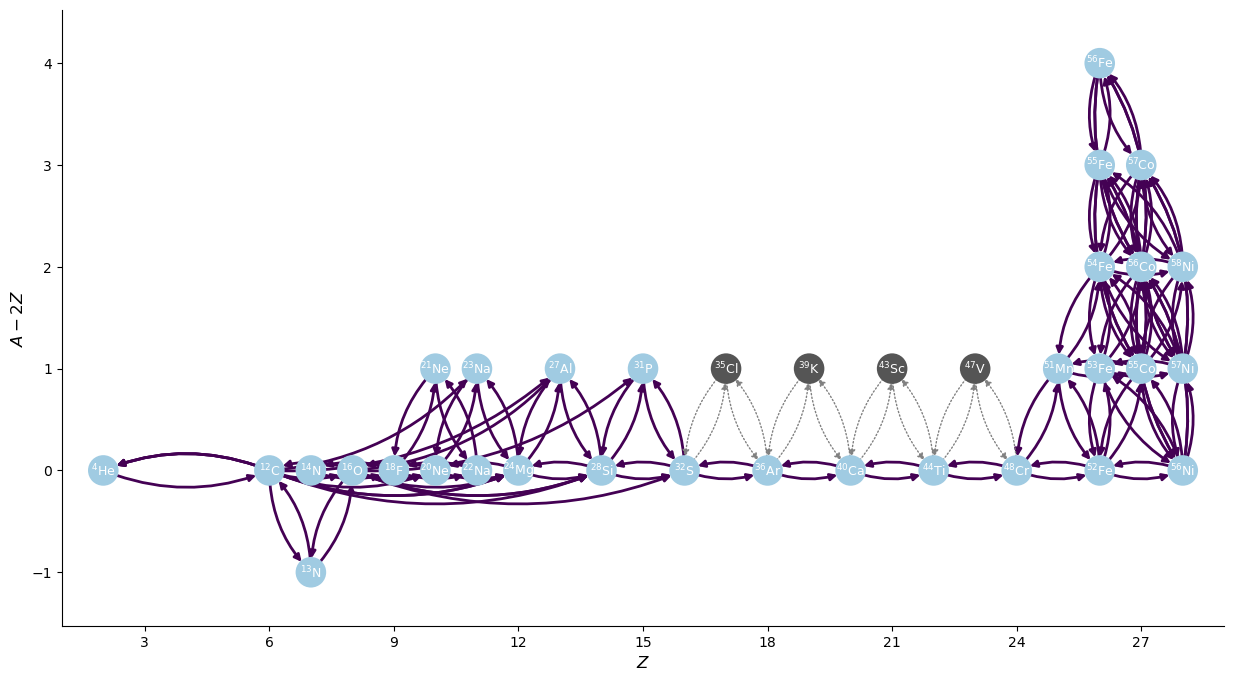

In [15]:
fig = net.plot(rotated=True, curved_edges=True, size=(1500, 800), hide_xalpha=True, node_size=400, node_font_size=9)

In [16]:
net.make_nn_g_approx(intermediate_nuclei=["fe53", "fe55", "ni57"])
net.remove_nuclei(["fe53", "fe55", "ni57"])

using approximate rate Fe52 + n + n ⟶ Fe54 + 𝛾
using approximate rate Fe54 ⟶ Fe52 + n + n
using approximate rate Fe54 + n + n ⟶ Fe56 + 𝛾
using approximate rate Fe56 ⟶ Fe54 + n + n
using approximate rate Ni56 + n + n ⟶ Ni58 + 𝛾
using approximate rate Ni58 ⟶ Ni56 + n + n
removing rate Fe52 + n ⟶ Fe53 + 𝛾
removing rate Fe53 + n ⟶ Fe54 + 𝛾
removing rate Fe54 ⟶ n + Fe53
removing rate Fe53 ⟶ n + Fe52
removing rate Fe54 + n ⟶ Fe55 + 𝛾
removing rate Fe55 + n ⟶ Fe56 + 𝛾
removing rate Fe56 ⟶ n + Fe55
removing rate Fe55 ⟶ n + Fe54
removing rate Ni56 + n ⟶ Ni57 + 𝛾
removing rate Ni57 + n ⟶ Ni58 + 𝛾
removing rate Ni58 ⟶ n + Ni57
removing rate Ni57 ⟶ n + Ni56
looking to remove Fe53 + He4 ⟶ Ni57 + 𝛾
looking to remove Fe53 + He4 ⟶ p + Co56
looking to remove Ni56 + n ⟶ He4 + Fe53
looking to remove Ni57 ⟶ He4 + Fe53
looking to remove Fe53 + He4 ⟶ n + Ni56
looking to remove Co56 + p ⟶ He4 + Fe53
looking to remove Fe55 + p ⟶ Co56 + 𝛾
looking to remove Co55 + n ⟶ p + Fe55
looking to remove Ni58 + n ⟶ He4 +

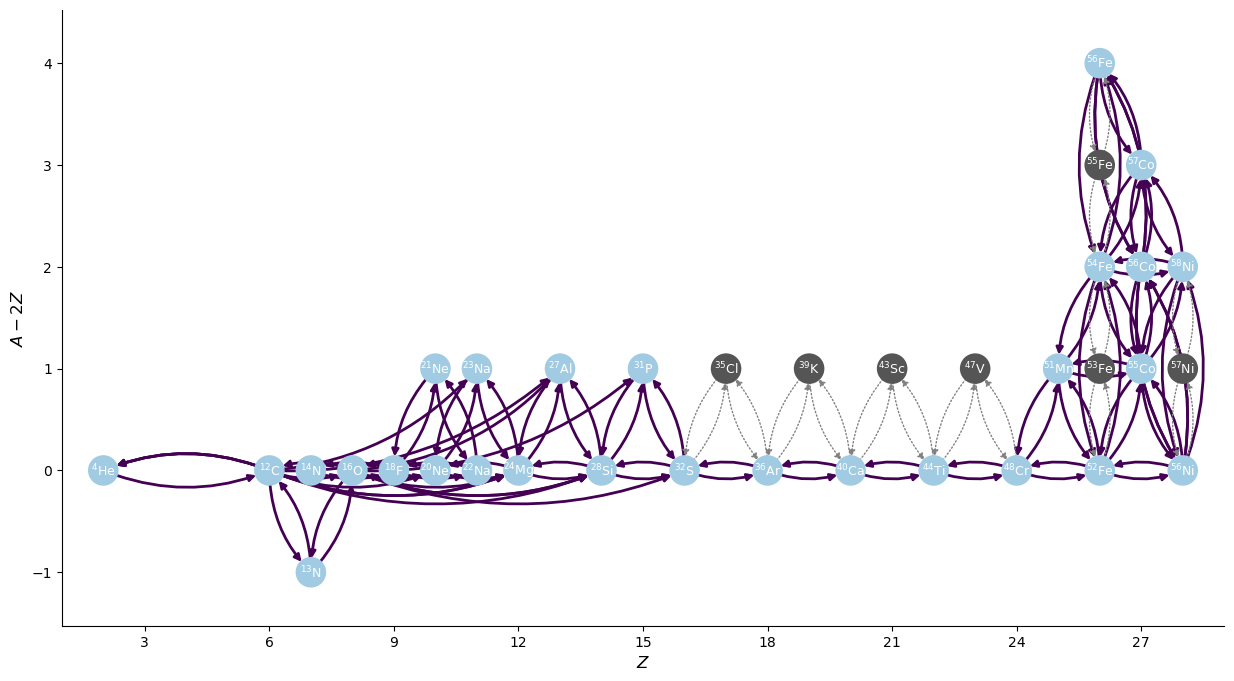

In [17]:
fig = net.plot(rotated=True, curved_edges=True, size=(1500, 800), hide_xalpha=True, node_size=400, node_font_size=9)

Now we'll add in the electron capture onto Ni56, but we'll change the end point to be Fe56 -- this is what `aprox21` does

In [18]:
fig.savefig("newnet.png")

In [20]:
tr = [r for r in net.get_rates() if isinstance(r, pyna.rates.TabularRate)]
tr

[Co56 + e⁻ ⟶ Fe56 + 𝜈,
 Co56 ⟶ Ni56 + e⁻ + 𝜈,
 Fe56 ⟶ Co56 + e⁻ + 𝜈,
 n ⟶ p + e⁻ + 𝜈,
 Ni56 + e⁻ ⟶ Co56 + 𝜈,
 p + e⁻ ⟶ n + 𝜈]

In [21]:
net.write_network()

/raid/zingale/development/pynucastro/pynucastro/rates/derived_rate.py:85: UserWarning: C12 partition function is not supported by tables: set pf = 1.0 by default
  warnings.warn(UserWarning(f'{nuc} partition function is not supported by tables: set pf = 1.0 by default'))
/raid/zingale/development/pynucastro/pynucastro/rates/derived_rate.py:85: UserWarning: N13 partition function is not supported by tables: set pf = 1.0 by default
  warnings.warn(UserWarning(f'{nuc} partition function is not supported by tables: set pf = 1.0 by default'))
/raid/zingale/development/pynucastro/pynucastro/rates/derived_rate.py:85: UserWarning: N14 partition function is not supported by tables: set pf = 1.0 by default
  warnings.warn(UserWarning(f'{nuc} partition function is not supported by tables: set pf = 1.0 by default'))


In [ ]:
ni56_cap = weak_lib.get_rate_by_name("ni56(,)co56")
ni56_cap_r = weak_lib.get_rate_by_name("fe56(,)co56")
ni56_cap, ni56_cap_r

In [ ]:
ni56_cap.modify_products("fe56")
ni56_cap_r.modify_prducts("ni56")
ni56_cap, ni56_cap_r

In [ ]:
len(net.get_rates())

In [ ]:
len(net.unique_nuclei)